# Detecting arrythmia using Deep Leaning

## Loading modules

In [1]:
import pandas as pd
import numpy as np
import wfdb
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Flatten, Conv1D, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Input, AveragePooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\mrall\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\mrall\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


## Download Dataset

In [3]:
import wget
import zipfile

database_filename = "mit-bih-arrhythmia-database-1.0.0.zip"
database_path = Path(database_filename)

if not database_path.exists():
    url = f'https://storage.googleapis.com/mitdb-1.0.0.physionet.org/{database_filename}'
    wget.download(url)
    with zipfile.ZipFile(database_filename, 'r') as zip_ref:
        zip_ref.extractall(".")

## Loading data

In [4]:
records = np.loadtxt("mit-bih-arrhythmia-database-1.0.0/RECORDS", dtype=int)

In [5]:
wfdb.show_ann_labels()

    label_store symbol                                    description
0             0                              Not an actual annotation
1             1      N                                    Normal beat
2             2      L                  Left bundle branch block beat
3             3      R                 Right bundle branch block beat
4             4      a                Aberrated atrial premature beat
5             5      V              Premature ventricular contraction
6             6      F          Fusion of ventricular and normal beat
7             7      J              Nodal (junctional) premature beat
8             8      A                   Atrial premature contraction
9             9      S     Premature or ectopic supraventricular beat
10           10      E                        Ventricular escape beat
11           11      j                 Nodal (junctional) escape beat
12           12      /                                     Paced beat
13           13     

In [6]:
invalid_beat = [
    "[", "]", "x", "(", ")", "p", "t", 
    "u", "`", "'", "^", "|", "~", "+", "s", 
    "T", "*", "D", "=", '"', "@"
]

normal_beats = ["N", "L", "R", "e", "j"]

ventricular_beats = ["V", "!", "E"]

supraventricular_beats = ["A", "a", "S", "J"]

fusion_beats = ["F"]

unknown_beats = ["/", "f", "Q"]

## Processing dataset

In [7]:
def classify_beat(symbol):
    if symbol in normal_beats:
        return [1, 0, 0, 0, 0]
    elif symbol in ventricular_beats:
        return [0, 1, 0, 0, 0]
    elif symbol in supraventricular_beats:
        return [0, 0, 1, 0, 0]
    elif symbol in fusion_beats:
        return [0, 0, 0, 1, 0]
    elif symbol in unknown_beats:
        return [0, 0, 0, 0, 1]

In [8]:
def get_sequence(signal, beat_loc, window_sec, fs):
    window_one_side = window_sec * fs
    beat_start = beat_loc - window_one_side
    beat_end = beat_loc + window_one_side
    if beat_end < signal.shape[0]:
        sequence = signal[beat_start:beat_end, 0]
        return sequence.reshape(1, -1, 1)
    else:
        return np.array([])

In [9]:
all_sequences = []
all_labels = []
window_sec = 3
subject_map = []
i = 0

for subject in records:
    record = wfdb.rdrecord(f'mit-bih-arrhythmia-database-1.0.0/{subject}')
    annotation = wfdb.rdann(f'mit-bih-arrhythmia-database-1.0.0/{subject}', 'atr')
    atr_symbol = annotation.symbol
    atr_sample = annotation.sample
    fs = record.fs
    scaler = StandardScaler()
    signal = scaler.fit_transform(record.p_signal)
    subject_labels = []
    for i, i_sample in enumerate(atr_sample):
        labels = classify_beat(atr_symbol[i])
        sequence = get_sequence(signal, i_sample, window_sec, fs)
        if labels is not None and sequence.size > 0:
            all_sequences.append(sequence)
            subject_labels.append(labels)
    
    normal_percentage = (subject_labels.count([0, 1, 0, 0, 0]) + subject_labels.count([0, 0, 1, 0, 0]) + 
                         subject_labels.count([0, 0, 0, 1, 0]) + subject_labels.count([0, 0, 0, 0, 1])) / len(subject_labels)
    subject_map.append({
        "subject": subject,
        #"percentage": normal_percentage,
        "num_seq": len(subject_labels),
        "start": len(all_labels),
        "end": len(all_labels)+len(subject_labels)
    })
    all_labels.extend(subject_labels)

In [10]:
subject_map = pd.DataFrame(subject_map)

In [11]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [12]:
train, valid, test = train_validate_test_split(subject_map, .6, .2, 4)

In [13]:
def build_dataset(df, all_sequences, all_labels):
    sequences = []
    labels = []
    for i, row in df.iterrows():
        start = int(row["start"])
        end = int(row["end"])
        sequences.extend(all_sequences[start:end])
        labels.extend(all_labels[start:end])
        
    return np.vstack(sequences), np.vstack(labels)

In [14]:
x_train, y_train = build_dataset(train, all_sequences, all_labels)
x_valid, y_valid = build_dataset(valid, all_sequences, all_labels)
x_test, y_test   = build_dataset(test, all_sequences, all_labels)

In [15]:
def get_labels(data):
    labels = []
    for i in data:
        if i[0] == 1:
            labels.append("Normal")
        elif i[1] == 1:
            labels.append("Ventricular")
        elif i[2] == 1:
            labels.append("Supraventricular")
        elif i[3] == 1:
            labels.append("Fusion")
        elif i[4] == 1:
            labels.append("Unknown")
            
    return labels

In [16]:
def get_counts(labels):
    (unique, counts) = np.unique(labels, return_counts=True)
    frequencies = np.asarray((unique, np.round(counts*100 / len(labels), 2))).T
    return frequencies

In [17]:
train_labels = get_labels(y_train)
valid_labels = get_labels(y_valid)
test_labels = get_labels(y_test)

print(f"Train labels:\n{get_counts(train_labels)}", f"Valid labels:\n{get_counts(valid_labels)}", 
      f"Test labels\n{get_counts(test_labels)}", sep="\n\n")

Train labels:
[['Fusion' '1.23']
 ['Normal' '82.55']
 ['Supraventricular' '3.07']
 ['Unknown' '6.6']
 ['Ventricular' '6.56']]

Valid labels:
[['Fusion' '0.08']
 ['Normal' '82.47']
 ['Supraventricular' '1.01']
 ['Unknown' '10.18']
 ['Ventricular' '6.26']]

Test labels
[['Fusion' '0.06']
 ['Normal' '82.05']
 ['Supraventricular' '2.4']
 ['Unknown' '6.8']
 ['Ventricular' '8.69']]


## Training the model

### CNN Model 1

In [18]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="relu"))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(5, activation="softmax", name="output"))

optimizer = Adam(lr=0.00007)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization (BatchNo (None, 2160, 8)           32        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2160, 8)           264       
_________________________________________________________________
dropout (Dropout)            (None, 2160, 8)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2160, 8)           264       
_________________________________________________________________
batch_normalization_1 (Batch (None, 2160, 8)           32        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2160, 16)          5

In [19]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=[callback], verbose = 2)

Epoch 1/100
490/490 - 27s - loss: 10.4704 - accuracy: 0.8413 - val_loss: 2.6210 - val_accuracy: 0.8244
Epoch 2/100
490/490 - 19s - loss: 2.3611 - accuracy: 0.8336 - val_loss: 1.3057 - val_accuracy: 0.8247
Epoch 3/100
490/490 - 19s - loss: 1.0080 - accuracy: 0.8684 - val_loss: 0.8752 - val_accuracy: 0.8247
Epoch 4/100
490/490 - 19s - loss: 0.7141 - accuracy: 0.8832 - val_loss: 0.7152 - val_accuracy: 0.8260
Epoch 5/100
490/490 - 19s - loss: 0.5751 - accuracy: 0.8958 - val_loss: 0.5945 - val_accuracy: 0.8676
Epoch 6/100
490/490 - 19s - loss: 0.4743 - accuracy: 0.9136 - val_loss: 0.5358 - val_accuracy: 0.8828
Epoch 7/100
490/490 - 19s - loss: 0.4080 - accuracy: 0.9249 - val_loss: 0.4924 - val_accuracy: 0.8984
Epoch 8/100
490/490 - 19s - loss: 0.3649 - accuracy: 0.9321 - val_loss: 0.4636 - val_accuracy: 0.8999
Epoch 9/100
490/490 - 19s - loss: 0.3344 - accuracy: 0.9369 - val_loss: 0.4512 - val_accuracy: 0.8975
Epoch 10/100
490/490 - 19s - loss: 0.3128 - accuracy: 0.9395 - val_loss: 0.4584 -

In [20]:
model.evaluate(x_test, y_test)

830/830 [==============================] - 6s 7ms/step - loss: 0.4766 - accuracy: 0.8846


[0.4766218960285187, 0.8846385478973389]

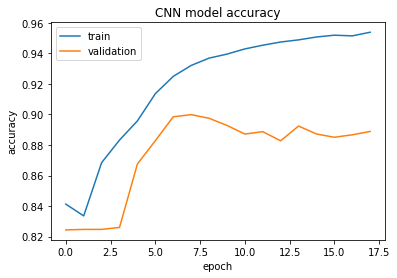

In [21]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

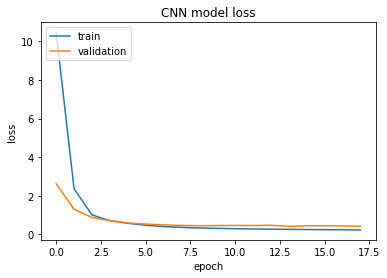

In [22]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN Model 2

In [23]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="sigmoid"))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=5e-4),
                 bias_regularizer=regularizers.l1(5e-5),
                 activity_regularizer=regularizers.l2(5e-4)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(5, activation="softmax", name="output"))

optimizer = Adam(lr=0.00007)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization_3 (Batch (None, 2160, 8)           32        
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 2160, 8)           264       
_________________________________________________________________
dropout_4 (Dropout)          (None, 2160, 8)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 2160, 8)           264       
_________________________________________________________________
batch_normalization_4 (Batch (None, 2160, 8)           32        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2160, 16)         

In [24]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=300, validation_data=(x_valid, y_valid), callbacks=[callback], verbose = 2)

Epoch 1/100
490/490 - 22s - loss: 17.0250 - accuracy: 0.8224 - val_loss: 13.7812 - val_accuracy: 0.8247
Epoch 2/100
490/490 - 19s - loss: 12.4074 - accuracy: 0.8254 - val_loss: 10.8601 - val_accuracy: 0.8247
Epoch 3/100
490/490 - 19s - loss: 9.3646 - accuracy: 0.8255 - val_loss: 8.3463 - val_accuracy: 0.8247
Epoch 4/100
490/490 - 19s - loss: 7.0889 - accuracy: 0.8255 - val_loss: 5.9522 - val_accuracy: 0.8247
Epoch 5/100
490/490 - 19s - loss: 5.5589 - accuracy: 0.8255 - val_loss: 4.7763 - val_accuracy: 0.8247
Epoch 6/100
490/490 - 19s - loss: 4.6025 - accuracy: 0.8255 - val_loss: 4.1082 - val_accuracy: 0.8247
Epoch 7/100
490/490 - 19s - loss: 3.9806 - accuracy: 0.8255 - val_loss: 3.6409 - val_accuracy: 0.8247
Epoch 8/100
490/490 - 19s - loss: 3.5298 - accuracy: 0.8255 - val_loss: 3.2592 - val_accuracy: 0.8247
Epoch 9/100
490/490 - 19s - loss: 3.1781 - accuracy: 0.8255 - val_loss: 2.9509 - val_accuracy: 0.8247
Epoch 10/100
490/490 - 19s - loss: 2.8624 - accuracy: 0.8280 - val_loss: 2.672

Epoch 81/100
490/490 - 20s - loss: 0.6747 - accuracy: 0.9452 - val_loss: 0.7905 - val_accuracy: 0.9138
Epoch 82/100
490/490 - 20s - loss: 0.6688 - accuracy: 0.9452 - val_loss: 0.7991 - val_accuracy: 0.9121
Epoch 83/100
490/490 - 20s - loss: 0.6644 - accuracy: 0.9449 - val_loss: 0.8007 - val_accuracy: 0.9101
Epoch 84/100
490/490 - 20s - loss: 0.6599 - accuracy: 0.9445 - val_loss: 0.7924 - val_accuracy: 0.9098
Epoch 85/100
490/490 - 20s - loss: 0.6541 - accuracy: 0.9449 - val_loss: 0.7907 - val_accuracy: 0.9084
Epoch 86/100
490/490 - 20s - loss: 0.6492 - accuracy: 0.9451 - val_loss: 0.7691 - val_accuracy: 0.9148
Epoch 87/100
490/490 - 20s - loss: 0.6451 - accuracy: 0.9454 - val_loss: 0.7859 - val_accuracy: 0.9110
Epoch 88/100
490/490 - 20s - loss: 0.6402 - accuracy: 0.9448 - val_loss: 0.7900 - val_accuracy: 0.9059
Epoch 89/100
490/490 - 20s - loss: 0.6342 - accuracy: 0.9455 - val_loss: 0.7600 - val_accuracy: 0.9125
Epoch 90/100
490/490 - 20s - loss: 0.6305 - accuracy: 0.9451 - val_loss: 

In [25]:
model.evaluate(x_test, y_test)

830/830 [==============================] - 6s 7ms/step - loss: 0.9021 - accuracy: 0.8840


[0.9021074175834656, 0.8839601874351501]

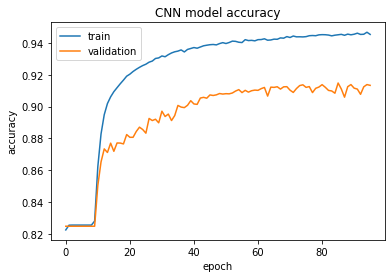

In [26]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

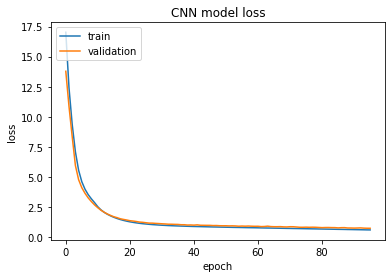

In [27]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN model 3

In [28]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="sigmoid"))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.4))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.4))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.4))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax", name="output"))

optimizer = Adam(lr=0.0001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization_6 (Batch (None, 2160, 8)           32        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 2160, 8)           264       
_________________________________________________________________
dropout_8 (Dropout)          (None, 2160, 8)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 2160, 8)           264       
_________________________________________________________________
batch_normalization_7 (Batch (None, 2160, 8)           32        
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 2160, 8)          

In [29]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=[callback], verbose = 2)

Epoch 1/100
490/490 - 19s - loss: 0.9786 - accuracy: 0.8233 - val_loss: 0.8371 - val_accuracy: 0.8247
Epoch 2/100
490/490 - 17s - loss: 0.9006 - accuracy: 0.8254 - val_loss: 0.8175 - val_accuracy: 0.8247
Epoch 3/100
490/490 - 17s - loss: 0.7357 - accuracy: 0.8443 - val_loss: 0.5967 - val_accuracy: 0.8900
Epoch 4/100
490/490 - 17s - loss: 0.4803 - accuracy: 0.9050 - val_loss: 0.5524 - val_accuracy: 0.8859
Epoch 5/100
490/490 - 17s - loss: 0.4083 - accuracy: 0.9189 - val_loss: 0.4950 - val_accuracy: 0.9012
Epoch 6/100
490/490 - 17s - loss: 0.3685 - accuracy: 0.9260 - val_loss: 0.4546 - val_accuracy: 0.9082
Epoch 7/100
490/490 - 17s - loss: 0.3428 - accuracy: 0.9307 - val_loss: 0.4522 - val_accuracy: 0.9075
Epoch 8/100
490/490 - 17s - loss: 0.3210 - accuracy: 0.9357 - val_loss: 0.4372 - val_accuracy: 0.9121
Epoch 9/100
490/490 - 17s - loss: 0.3049 - accuracy: 0.9393 - val_loss: 0.4154 - val_accuracy: 0.9182
Epoch 10/100
490/490 - 17s - loss: 0.2848 - accuracy: 0.9437 - val_loss: 0.3918 - 

In [30]:
predictions = model.predict(x=x_test, verbose=0)

In [31]:
model.evaluate(x_test, y_test)

830/830 [==============================] - 7s 9ms/step - loss: 0.4463 - accuracy: 0.9049


[0.4463467001914978, 0.9049144387245178]

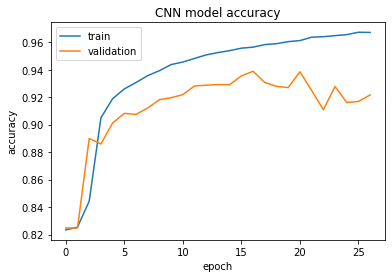

In [32]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

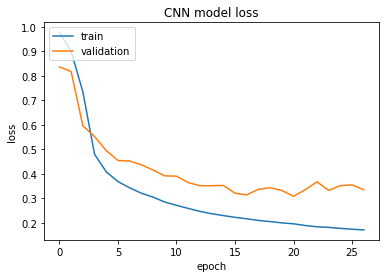

In [33]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN model 4

In [34]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="sigmoid"))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
#model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
#model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
#model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="sigmoid", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(5, activation="softmax", name="output"))

optimizer = Adam(lr=0.00003)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization_9 (Batch (None, 2160, 8)           32        
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 2160, 8)           264       
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2160, 8)           264       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1080, 8)           0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 1080, 8)           32        
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1080, 8)          

In [35]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=[callback], verbose = 2)

Epoch 1/100
490/490 - 16s - loss: 1.2814 - accuracy: 0.7784 - val_loss: 1.0810 - val_accuracy: 0.8247
Epoch 2/100
490/490 - 13s - loss: 1.1261 - accuracy: 0.8254 - val_loss: 1.0370 - val_accuracy: 0.8247
Epoch 3/100
490/490 - 12s - loss: 1.0778 - accuracy: 0.8254 - val_loss: 1.0006 - val_accuracy: 0.8247
Epoch 4/100
490/490 - 13s - loss: 1.0346 - accuracy: 0.8255 - val_loss: 0.9640 - val_accuracy: 0.8247
Epoch 5/100
490/490 - 13s - loss: 0.9943 - accuracy: 0.8255 - val_loss: 0.9258 - val_accuracy: 0.8247
Epoch 6/100
490/490 - 13s - loss: 0.9456 - accuracy: 0.8255 - val_loss: 0.8811 - val_accuracy: 0.8247
Epoch 7/100
490/490 - 13s - loss: 0.8884 - accuracy: 0.8267 - val_loss: 0.8338 - val_accuracy: 0.8247
Epoch 8/100
490/490 - 13s - loss: 0.8253 - accuracy: 0.8353 - val_loss: 0.7787 - val_accuracy: 0.8259
Epoch 9/100
490/490 - 13s - loss: 0.7643 - accuracy: 0.8519 - val_loss: 0.7318 - val_accuracy: 0.8410
Epoch 10/100
490/490 - 13s - loss: 0.7088 - accuracy: 0.8641 - val_loss: 0.6931 - 

In [36]:
model.evaluate(x_test, y_test)

830/830 [==============================] - 6s 7ms/step - loss: 0.3852 - accuracy: 0.9205


[0.38515612483024597, 0.920517086982727]

In [37]:
predictions = model.predict(x=x_test, verbose=0)

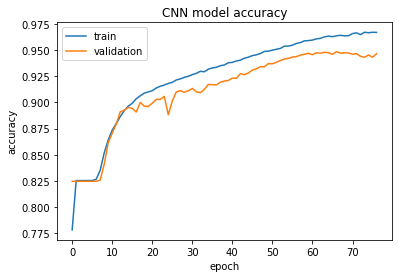

In [38]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

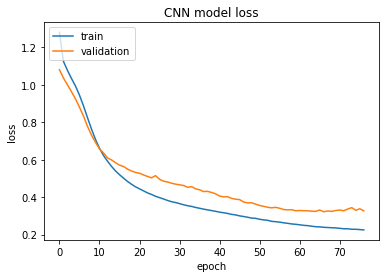

In [39]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN Model 5!

In [40]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="relu"))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
#model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
#model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
#model.add(Dropout(0.2))
model.add(Conv1D(filters=8, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=3e-5, l2=3e-4),
                 bias_regularizer=regularizers.l1(3e-4),
                 activity_regularizer=regularizers.l2(3e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(5, activation="softmax", name="output"))

optimizer = Adam(lr=0.00003)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_28 (Conv1D)           (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization_12 (Batc (None, 2160, 8)           32        
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 2160, 8)           264       
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 2160, 8)           264       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1080, 8)           0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 1080, 8)           32        
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1080, 8)          

In [41]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=[callback], verbose = 2)

Epoch 1/100
490/490 - 15s - loss: 1.4043 - accuracy: 0.7673 - val_loss: 0.9120 - val_accuracy: 0.8282
Epoch 2/100
490/490 - 12s - loss: 0.9690 - accuracy: 0.8427 - val_loss: 0.7725 - val_accuracy: 0.9165
Epoch 3/100
490/490 - 12s - loss: 0.7670 - accuracy: 0.8673 - val_loss: 0.6620 - val_accuracy: 0.9144
Epoch 4/100
490/490 - 12s - loss: 0.6236 - accuracy: 0.8882 - val_loss: 0.5896 - val_accuracy: 0.9154
Epoch 5/100
490/490 - 12s - loss: 0.5224 - accuracy: 0.9073 - val_loss: 0.5435 - val_accuracy: 0.9163
Epoch 6/100
490/490 - 12s - loss: 0.4504 - accuracy: 0.9218 - val_loss: 0.4965 - val_accuracy: 0.9200
Epoch 7/100
490/490 - 12s - loss: 0.3980 - accuracy: 0.9312 - val_loss: 0.4690 - val_accuracy: 0.9201
Epoch 8/100
490/490 - 12s - loss: 0.3581 - accuracy: 0.9379 - val_loss: 0.4452 - val_accuracy: 0.9178
Epoch 9/100
490/490 - 12s - loss: 0.3269 - accuracy: 0.9425 - val_loss: 0.4257 - val_accuracy: 0.9180
Epoch 10/100
490/490 - 12s - loss: 0.3013 - accuracy: 0.9477 - val_loss: 0.4076 - 

In [42]:
model.evaluate(x_test, y_test)

830/830 [==============================] - 6s 7ms/step - loss: 0.3174 - accuracy: 0.9246


[0.317376047372818, 0.9245873093605042]

In [43]:
predictions = model.predict(x=x_test, verbose=0)

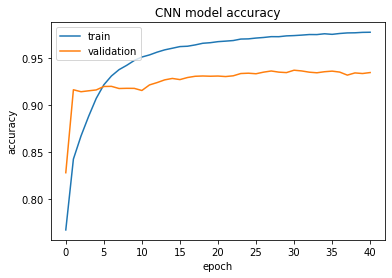

In [44]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

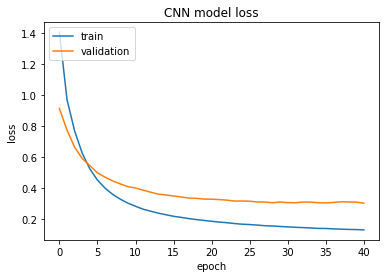

In [45]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN Model 6

In [46]:
sequence_size = x_train.shape[1]
n_features = 1
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model = Sequential()

model.add(Conv1D(filters=8, kernel_size=4, input_shape=(sequence_size, n_features), padding="same", activation="relu"))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(BatchNormalization())
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.3))
model.add(Conv1D(filters=16, kernel_size=4, padding="same", activation="relu", 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                 bias_regularizer=regularizers.l1(1e-4),
                 activity_regularizer=regularizers.l2(1e-5)))
model.add(MaxPooling1D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5, activation="softmax", name="output"))

optimizer = Adam(lr=0.0001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 2160, 8)           40        
_________________________________________________________________
batch_normalization_15 (Batc (None, 2160, 8)           32        
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 2160, 16)          528       
_________________________________________________________________
dropout_14 (Dropout)         (None, 2160, 16)          0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 2160, 16)          1040      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1080, 16)          0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 1080, 16)         

In [47]:
hist_cnn = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_valid, y_valid), callbacks=[callback], verbose = 2)

Epoch 1/100
490/490 - 25s - loss: 1.2066 - accuracy: 0.7865 - val_loss: 0.7990 - val_accuracy: 0.8247
Epoch 2/100
490/490 - 21s - loss: 0.8206 - accuracy: 0.8407 - val_loss: 0.8132 - val_accuracy: 0.8247
Epoch 3/100
490/490 - 21s - loss: 0.6239 - accuracy: 0.8713 - val_loss: 0.9311 - val_accuracy: 0.8246
Epoch 4/100
490/490 - 22s - loss: 0.5277 - accuracy: 0.8855 - val_loss: 0.8486 - val_accuracy: 0.8246
Epoch 5/100
490/490 - 21s - loss: 0.4637 - accuracy: 0.8961 - val_loss: 0.7956 - val_accuracy: 0.8248
Epoch 6/100
490/490 - 21s - loss: 0.4174 - accuracy: 0.9043 - val_loss: 0.7369 - val_accuracy: 0.8256
Epoch 7/100
490/490 - 21s - loss: 0.3820 - accuracy: 0.9106 - val_loss: 0.6492 - val_accuracy: 0.8328
Epoch 8/100
490/490 - 21s - loss: 0.3480 - accuracy: 0.9176 - val_loss: 0.6094 - val_accuracy: 0.8426
Epoch 9/100
490/490 - 21s - loss: 0.3184 - accuracy: 0.9256 - val_loss: 0.5364 - val_accuracy: 0.8425
Epoch 10/100
490/490 - 21s - loss: 0.2972 - accuracy: 0.9298 - val_loss: 0.5440 - 

In [48]:
model.evaluate(x_test, y_test)

830/830 [==============================] - 9s 11ms/step - loss: 0.3204 - accuracy: 0.9268


[0.3203997015953064, 0.926773190498352]

In [49]:
predictions = model.predict(x=x_test, verbose=0)

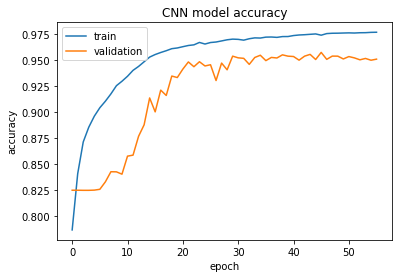

In [50]:
# summarize history for accuracy
plt.plot(hist_cnn.history['accuracy'])
plt.plot(hist_cnn.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

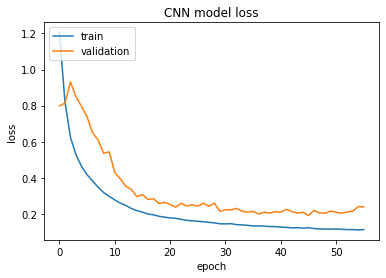

In [51]:
# summarize history for loss
plt.plot(hist_cnn.history['loss'])
plt.plot(hist_cnn.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Model saving

In [23]:
import os
os.remove("C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model.h5")
model.save('C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model.h5')

# Model loading

In [24]:
from tensorflow.keras.models import load_model
new_model = load_model('C:\\Users\\mrall\\Desktop\\Thesis\\Experiments\\Models\\Model.h5')

In [114]:
for i in range(0, 100):
    train, valid, test = train_validate_test_split(subject_map, .5, .25, i)

    x_train, y_train = build_dataset(train, all_sequences, all_labels)
    x_valid, y_valid = build_dataset(valid, all_sequences, all_labels)
    x_test, y_test   = build_dataset(test, all_sequences, all_labels)

    train_labels = get_labels(y_train)
    valid_labels = get_labels(y_valid)
    test_labels = get_labels(y_test)
    print(i)
    print(f"Train labels:\n{get_counts(train_labels)}", f"Valid labels:\n{get_counts(valid_labels)}", 
          f"Test labels\n{get_counts(test_labels)}", sep="\n\n")

0
Train labels:
[['Fusion' '1.33']
 ['Normal' '78.28']
 ['Supraventricular' '1.57']
 ['Unknown' '10.53']
 ['Ventricular' '8.29']]

Valid labels:
[['Fusion' '0.03']
 ['Normal' '96.32']
 ['Supraventricular' '1.06']
 ['Unknown' '0.03']
 ['Ventricular' '2.56']]

Test labels
[['Fusion' '0.02']
 ['Normal' '77.72']
 ['Supraventricular' '6.35']
 ['Unknown' '7.25']
 ['Ventricular' '8.65']]
1
Train labels:
[['Fusion' '0.73']
 ['Normal' '79.11']
 ['Supraventricular' '1.46']
 ['Unknown' '10.58']
 ['Ventricular' '8.12']]

Valid labels:
[['Fusion' '1.37']
 ['Normal' '79.23']
 ['Supraventricular' '1.84']
 ['Unknown' '7.37']
 ['Ventricular' '10.19']]

Test labels
[['Fusion' '0.02']
 ['Normal' '93.23']
 ['Supraventricular' '5.65']
 ['Unknown' '0.03']
 ['Ventricular' '1.07']]
2
Train labels:
[['Fusion' '1.39']
 ['Normal' '82.81']
 ['Supraventricular' '1.61']
 ['Unknown' '7.03']
 ['Ventricular' '7.15']]

Valid labels:
[['Fusion' '0.01']
 ['Normal' '84.31']
 ['Supraventricular' '0.41']
 ['Unknown' '7.49']

22
Train labels:
[['Fusion' '0.68']
 ['Normal' '85.69']
 ['Supraventricular' '4.13']
 ['Unknown' '3.74']
 ['Ventricular' '5.75']]

Valid labels:
[['Fusion' '0.1']
 ['Normal' '84.12']
 ['Supraventricular' '1.15']
 ['Unknown' '7.72']
 ['Ventricular' '6.89']]

Test labels
[['Fusion' '1.45']
 ['Normal' '73.99']
 ['Supraventricular' '0.6']
 ['Unknown' '14.22']
 ['Ventricular' '9.73']]
23
Train labels:
[['Fusion' '1.4']
 ['Normal' '76.56']
 ['Supraventricular' '1.54']
 ['Unknown' '10.91']
 ['Ventricular' '9.59']]

Valid labels:
[['Fusion' '0.05']
 ['Normal' '89.06']
 ['Supraventricular' '0.59']
 ['Unknown' '7.44']
 ['Ventricular' '2.86']]

Test labels
[['Fusion' '0.09']
 ['Normal' '87.25']
 ['Supraventricular' '6.49']
 ['Unknown' '0.01']
 ['Ventricular' '6.15']]
24
Train labels:
[['Fusion' '1.39']
 ['Normal' '86.24']
 ['Supraventricular' '1.57']
 ['Unknown' '3.79']
 ['Ventricular' '7.01']]

Valid labels:
[['Fusion' '0.12']
 ['Normal' '78.78']
 ['Supraventricular' '6.49']
 ['Unknown' '7.71']


44
Train labels:
[['Fusion' '0.71']
 ['Normal' '82.49']
 ['Supraventricular' '1.94']
 ['Unknown' '6.85']
 ['Ventricular' '8.01']]

Valid labels:
[['Fusion' '1.5']
 ['Normal' '83.9']
 ['Supraventricular' '0.2']
 ['Unknown' '8.2']
 ['Ventricular' '6.2']]

Test labels
[['Fusion' '0.08']
 ['Normal' '80.9']
 ['Supraventricular' '5.84']
 ['Unknown' '7.45']
 ['Ventricular' '5.73']]
45
Train labels:
[['Fusion' '0.75']
 ['Normal' '78.84']
 ['Supraventricular' '3.38']
 ['Unknown' '7.63']
 ['Ventricular' '9.4']]

Valid labels:
[['Fusion' '1.4']
 ['Normal' '82.4']
 ['Supraventricular' '1.88']
 ['Unknown' '6.65']
 ['Ventricular' '7.68']]

Test labels
[['Fusion' '0.05']
 ['Normal' '89.37']
 ['Supraventricular' '1.5']
 ['Unknown' '7.34']
 ['Ventricular' '1.74']]
46
Train labels:
[['Fusion' '0.73']
 ['Normal' '82.65']
 ['Supraventricular' '3.25']
 ['Unknown' '7.65']
 ['Ventricular' '5.73']]

Valid labels:
[['Fusion' '0.04']
 ['Normal' '80.45']
 ['Supraventricular' '2.79']
 ['Unknown' '6.49']
 ['Ventri

66
Train labels:
[['Fusion' '0.69']
 ['Normal' '80.38']
 ['Supraventricular' '3.82']
 ['Unknown' '10.82']
 ['Ventricular' '4.3']]

Valid labels:
[['Fusion' '0.05']
 ['Normal' '82.28']
 ['Supraventricular' '2.2']
 ['Unknown' '7.92']
 ['Ventricular' '7.54']]

Test labels
[['Fusion' '1.44']
 ['Normal' '86.43']
 ['Supraventricular' '0.35']
 ['Unknown' '0.02']
 ['Ventricular' '11.75']]
67
Train labels:
[['Fusion' '1.39']
 ['Normal' '82.52']
 ['Supraventricular' '3.27']
 ['Unknown' '3.75']
 ['Ventricular' '9.08']]

Valid labels:
[['Fusion' '0.05']
 ['Normal' '77.16']
 ['Supraventricular' '2.45']
 ['Unknown' '14.84']
 ['Ventricular' '5.49']]

Test labels
[['Fusion' '0.08']
 ['Normal' '87.02']
 ['Supraventricular' '1.17']
 ['Unknown' '7.29']
 ['Ventricular' '4.44']]
68
Train labels:
[['Fusion' '0.74']
 ['Normal' '76.65']
 ['Supraventricular' '3.98']
 ['Unknown' '11.16']
 ['Ventricular' '7.47']]

Valid labels:
[['Fusion' '1.37']
 ['Normal' '93.71']
 ['Supraventricular' '1.0']
 ['Unknown' '0.03'

88
Train labels:
[['Fusion' '0.74']
 ['Normal' '80.13']
 ['Supraventricular' '4.59']
 ['Unknown' '7.37']
 ['Ventricular' '7.18']]

Valid labels:
[['Fusion' '0.12']
 ['Normal' '84.13']
 ['Supraventricular' '0.42']
 ['Unknown' '7.45']
 ['Ventricular' '7.87']]

Test labels
[['Fusion' '1.3']
 ['Normal' '84.88']
 ['Supraventricular' '0.83']
 ['Unknown' '7.07']
 ['Ventricular' '5.91']]
89
Train labels:
[['Fusion' '0.07']
 ['Normal' '88.54']
 ['Supraventricular' '3.82']
 ['Unknown' '3.79']
 ['Ventricular' '3.77']]

Valid labels:
[['Fusion' '1.41']
 ['Normal' '71.17']
 ['Supraventricular' '0.32']
 ['Unknown' '14.52']
 ['Ventricular' '12.58']]

Test labels
[['Fusion' '1.37']
 ['Normal' '81.11']
 ['Supraventricular' '2.11']
 ['Unknown' '7.34']
 ['Ventricular' '8.08']]
90
Train labels:
[['Fusion' '0.73']
 ['Normal' '81.58']
 ['Supraventricular' '1.29']
 ['Unknown' '7.66']
 ['Ventricular' '8.74']]

Valid labels:
[['Fusion' '0.03']
 ['Normal' '84.19']
 ['Supraventricular' '6.15']
 ['Unknown' '6.69'

IndexError: string index out of range